In [1]:
# Cell Type Annotation Tutorial - for Spatial Transcriptomic Dataset

# Example Data:
# Hepatocellular carcinoma (HCC) resection specimens
# Publication link: https://pubmed.ncbi.nlm.nih.gov/37723590/

# This Data is Already Processed using st_tutorial_AKS.ipynb
# Processed Data was stored in "GSE238264_finalProcessedData.h5ad"

# In this Tutorial we will explore the Step5 (Cell Types Annotation ) in Detail

# By: Ashok K. Sharma
# Date: 11-13-2024

In [2]:
# Setup R path to use R in Python using rpy2
# To call R from Python; Check you R installation path and than call it in the Python Environment
import os

# Set R_HOME to the correct path
os.environ['R_HOME'] = '/opt/homebrew/Cellar/r/4.4.2_1/lib/R'  # replace if needed based on output of the R.home() command
os.environ['R_PATH'] = '/opt/homebrew/bin/R'  # path to the R executable

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import time
from umap import UMAP # this is installed by us
from sklearn.cluster import KMeans # For Clustering
import scanpy as sc
import celltypist

# set plot style
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('talk')

# These packages 
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# If need to install specific Pacakges using rpy2 like singleR and seurat
# import rpy2.robjects as ro

# Using BioManager
# ro.r('if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")') ## Activate BiocManager
# ro.r('BiocManager::install("SingleR")') ## Install SingleR
# ro.r('install.packages("Seurat")') ## Install Seurat
# Install devtools if it's not installed

# Using DevTools
#ro.r('if (!requireNamespace("devtools", quietly = TRUE)) install.packages("devtools")')
## Install Azimuth from GitHub using devtools
#ro.r('devtools::install_github("satijalab/Azimuth")')

# Using remotes
#ro.r('''
#if (!requireNamespace("remotes", quietly = TRUE)) {
#  install.packages("remotes")
#}
#remotes::install_github("satijalab/azimuth", ref = "master")
#''')

from rpy2.robjects.packages import importr

singleR = importr('SingleR')
seurat = importr('Seurat')
print("SingleR and Seurat loaded successfully.")

cffi mode is CFFI_MODE.ANY
R home found: /opt/homebrew/Cellar/r/4.4.2_1/lib/R
R library path: 
LD_LIBRARY_PATH: 
Default options to initialize R: rpy2, --quiet, --no-save
R is already initialized. No need to initialize.



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    SingleR and Seurat loaded successfully.


In [7]:
# Activate automatic conversion between R and pandas objects
pandas2ri.activate()

# Load your AnnData object (already processed with UMAP, clustering, and initial annotation)
combined_ad = sc.read("data/GSE238264_normalized.h5ad") # Only Normaliztion
#combined_ad = sc.read("data/GSE238264_finalProcessedData.h5ad") # With Annotation only using Cell Typist 

## Just to Save Some Memory: Use smaller subset
## Option 1: Downsample the dataset (e.g., use only 5000 cells)
#combined_ad = combined_ad[:5000, :]  # Adjust the number as needed
# Option 2: Use highly variable genes only
sc.pp.highly_variable_genes(combined_ad, n_top_genes=10000)  # Keeping top 10000 genes
combined_ad = combined_ad[:, combined_ad.var['highly_variable']]

# --------------------------------------------------------------------
# 1. Using CellTypist (already done, but loading the annotations)
# --------------------------------------------------------------------
# File paths for liver-specific markers and CellTypist model
model_path = '/Users/sharmaa4/.celltypist/data/models/Healthy_Human_Liver.pkl'  # Healthy Human Liver Model
## Use CellTypist to predict cell types
predictions = celltypist.annotate(combined_ad, model=model_path)
combined_ad.obs["predicted_cell_type"] = predictions.predicted_labels

# --------------------------------------------------------------------
# 2. Using SingleR (requires R in Python with rpy2 and R libraries SingleR, celldex)
# --------------------------------------------------------------------
# Load required R packages and liver reference data
# Extract expression matrix as a pandas DataFrame
data_matrix_df = pd.DataFrame(combined_ad.X.toarray(), index=combined_ad.obs_names, columns=combined_ad.var_names)
# Transpose the DataFrame so rows are genes and columns are samples
data_matrix_df = data_matrix_df.T

## Push the DataFrame to R and convert to SingleCellExperiment
ro.globalenv['data_matrix_df'] = data_matrix_df

# R Code: Define SingleCellExperiment and specify counts for SingleR
ro.r('''
    library(SingleR)
    library(celldex)
    library(SingleCellExperiment)

    # Create SingleCellExperiment object with the counts assay from normalized data
    se <- SingleCellExperiment(assays = list(counts = as.matrix(data_matrix_df)))

    # Load reference data for cell annotation
    ref_data <- celldex::HumanPrimaryCellAtlasData()
 
    print(head(rownames(se)))
    print(head(rownames(ref_data)))
    #print(head(colnames(se)))
    #print(head(colnames(ref_data)))

    # Run SingleR using counts as the assay type
    singleR_result <- SingleR(test = se, ref = ref_data, labels = ref_data$label.main, assay.type.test = "counts")
    
''')

# Check the dimensions of `singleR_result` in R to understand the mismatch
ro.r('''
    print(dim(singleR_result))
    print(length(singleR_result$labels))
    print(length(colnames(singleR_result)))
''')
# Adjusting the row names based on actual lengths to create the DataFrame in R
ro.r('''
    # Create a data frame without specifying row names directly
    singleR_df <- data.frame(SingleR_annotation = singleR_result$labels)
''')
# Retrieve the DataFrame from R to Python
singleR_df = ro.r('singleR_df')

# Convert the R DataFrame to a Pandas DataFrame
singleR_df_py = pandas2ri.rpy2py(singleR_df)
# Add the annotation to the `obs` attribute of your AnnData object
combined_ad.obs["SingleR_annotation"] = singleR_df_py["SingleR_annotation"].values
## Verify the results
print(combined_ad.obs["SingleR_annotation"].head())

# --------------------------------------------------------------------
# 3. Using Azimuth (Seurat-based annotation with liver reference)
# --------------------------------------------------------------------
## Load Seurat and Azimuth packages in R
#ro.r('''
#library(Seurat)
#library(Azimuth)

## Define function to create Seurat object from AnnData and annotate with Azimuth liver reference
#create_and_run_azimuth <- function(adata) {
#    seurat_data <- CreateSeuratObject(counts = as.matrix(adata$X))
#    seurat_data <- SCTransform(seurat_data, verbose = FALSE)
#    seurat_data <- Azimuth::Azimuth(seurat_data, reference = Azimuth::HumanLiver())
#    seurat_data$predicted.celltype
#}
#''')

## Annotate with Azimuth
#azimuth_result = ro.globalenv['create_and_run_azimuth'](se_object)
#combined_ad.obs["Azimuth_annotation"] = pandas2ri.rpy2py(azimuth_result)

# --------------------------------------------------------------------
# 4. Using scType (marker-based annotation using liver-specific markers)
# --------------------------------------------------------------------
# Ensure scType is installed (https://sctype.app)
# https://github.com/IanevskiAleksandr/sc-type
#!pip3 install scType
#import scType

# https://sctype.app/database.php: ScTypeDB_markeres.csv; # e.g. Immune system, Liver, Pancreas, Kidney, Eye, Brain
# Get only Liver Markers: ScTypeDB_Liver_markeres.csv

## Load custom liver marker gene file
#dummy_marker_genes = pd.read_csv(cell_marker_file)
#marker_genes = pd.read_csv(ScTypeDB_Liver_markeres.csv)

## Assign scType annotations based on liver markers
#scType_labels = scType.annotate_scType(combined_ad, marker_genes)
#combined_ad.obs["scType_annotation"] = scType_labels

⚠️ Warning: invalid expression matrix, expect ALL genes and log1p normalized expression to 10000 counts per cell. The prediction result may not be accurate
🔬 Input data has 17292 cells and 10000 genes
🔗 Matching reference genes in the model
🧬 1456 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


[1] "LINC01128" "LINC00115" "LINC02593" "NOC2L"     "KLHL17"    "PLEKHN1"  
[1] "A1BG"     "A1BG-AS1" "A1CF"     "A2M"      "A2M-AS1"  "A2ML1"   
[1] 17292     4
[1] 17292
[1] 4
AAACAGAGCGACTCCT-1-HCC5NR    Hepatocytes
AAACAGCTTTCAGAAG-1-HCC5NR    Hepatocytes
AAACAGGGTCTATATT-1-HCC5NR    Hepatocytes
AAACCGGGTAGGTACC-1-HCC5NR    Hepatocytes
AAACCTCATGAAGTTG-1-HCC5NR    Hepatocytes
Name: SingleR_annotation, dtype: object


... storing 'SingleR_annotation' as categorical


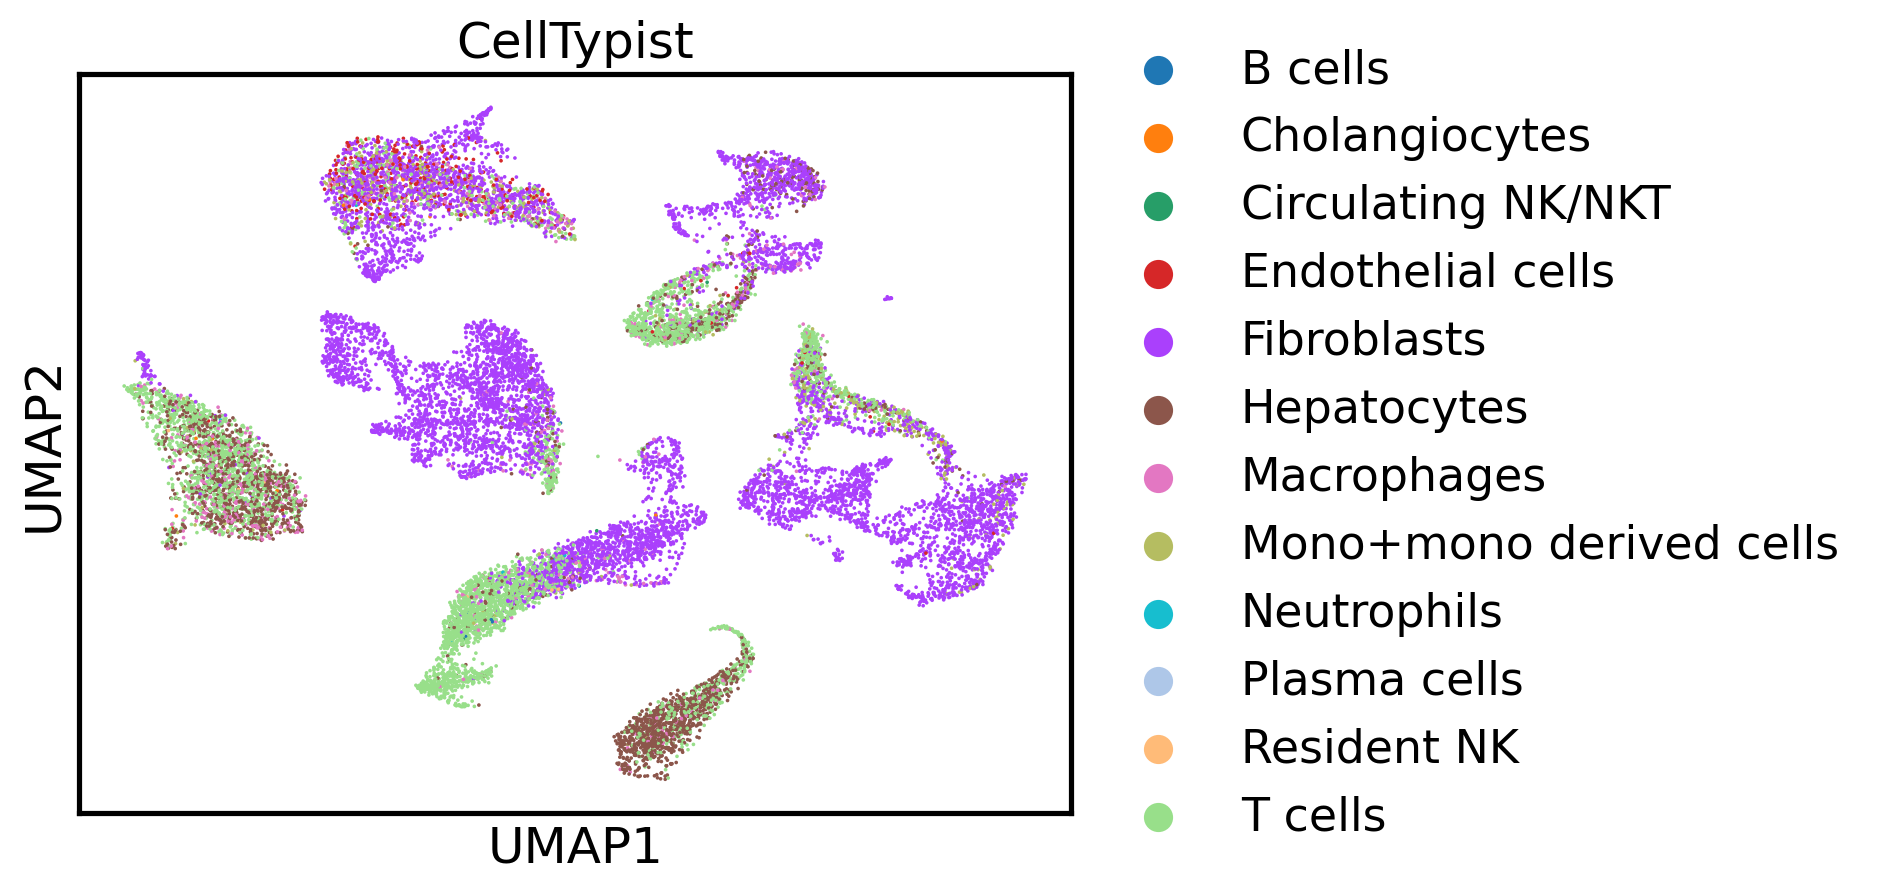

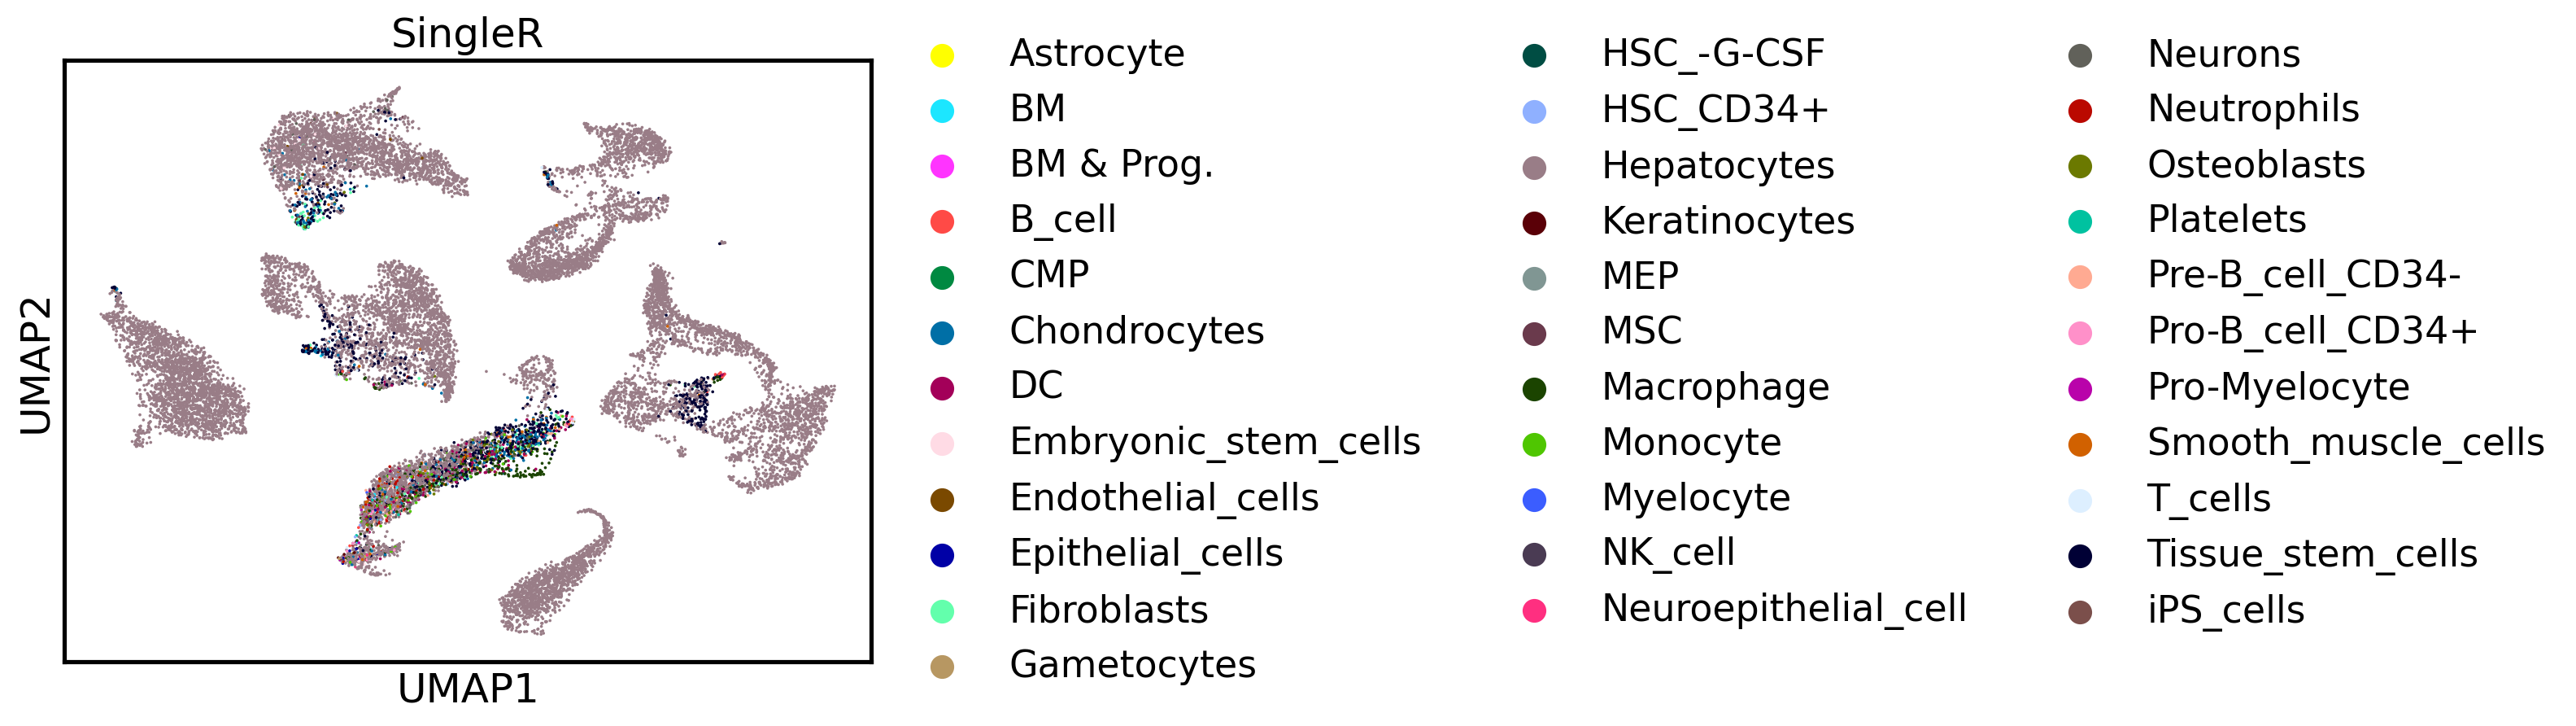

In [8]:
# Annotations are done on Filtered DataSet: 10000 Genes to reduce memory use
# Cell Typist Annotation
sc.pl.umap(combined_ad, color="predicted_cell_type", title="CellTypist", show=False)
# Single R Annotation
sc.pl.umap(combined_ad, color="SingleR_annotation", title="SingleR", show=False)

combined_ad.write("data/GSE238264_normalized_liver_annotations.h5ad")

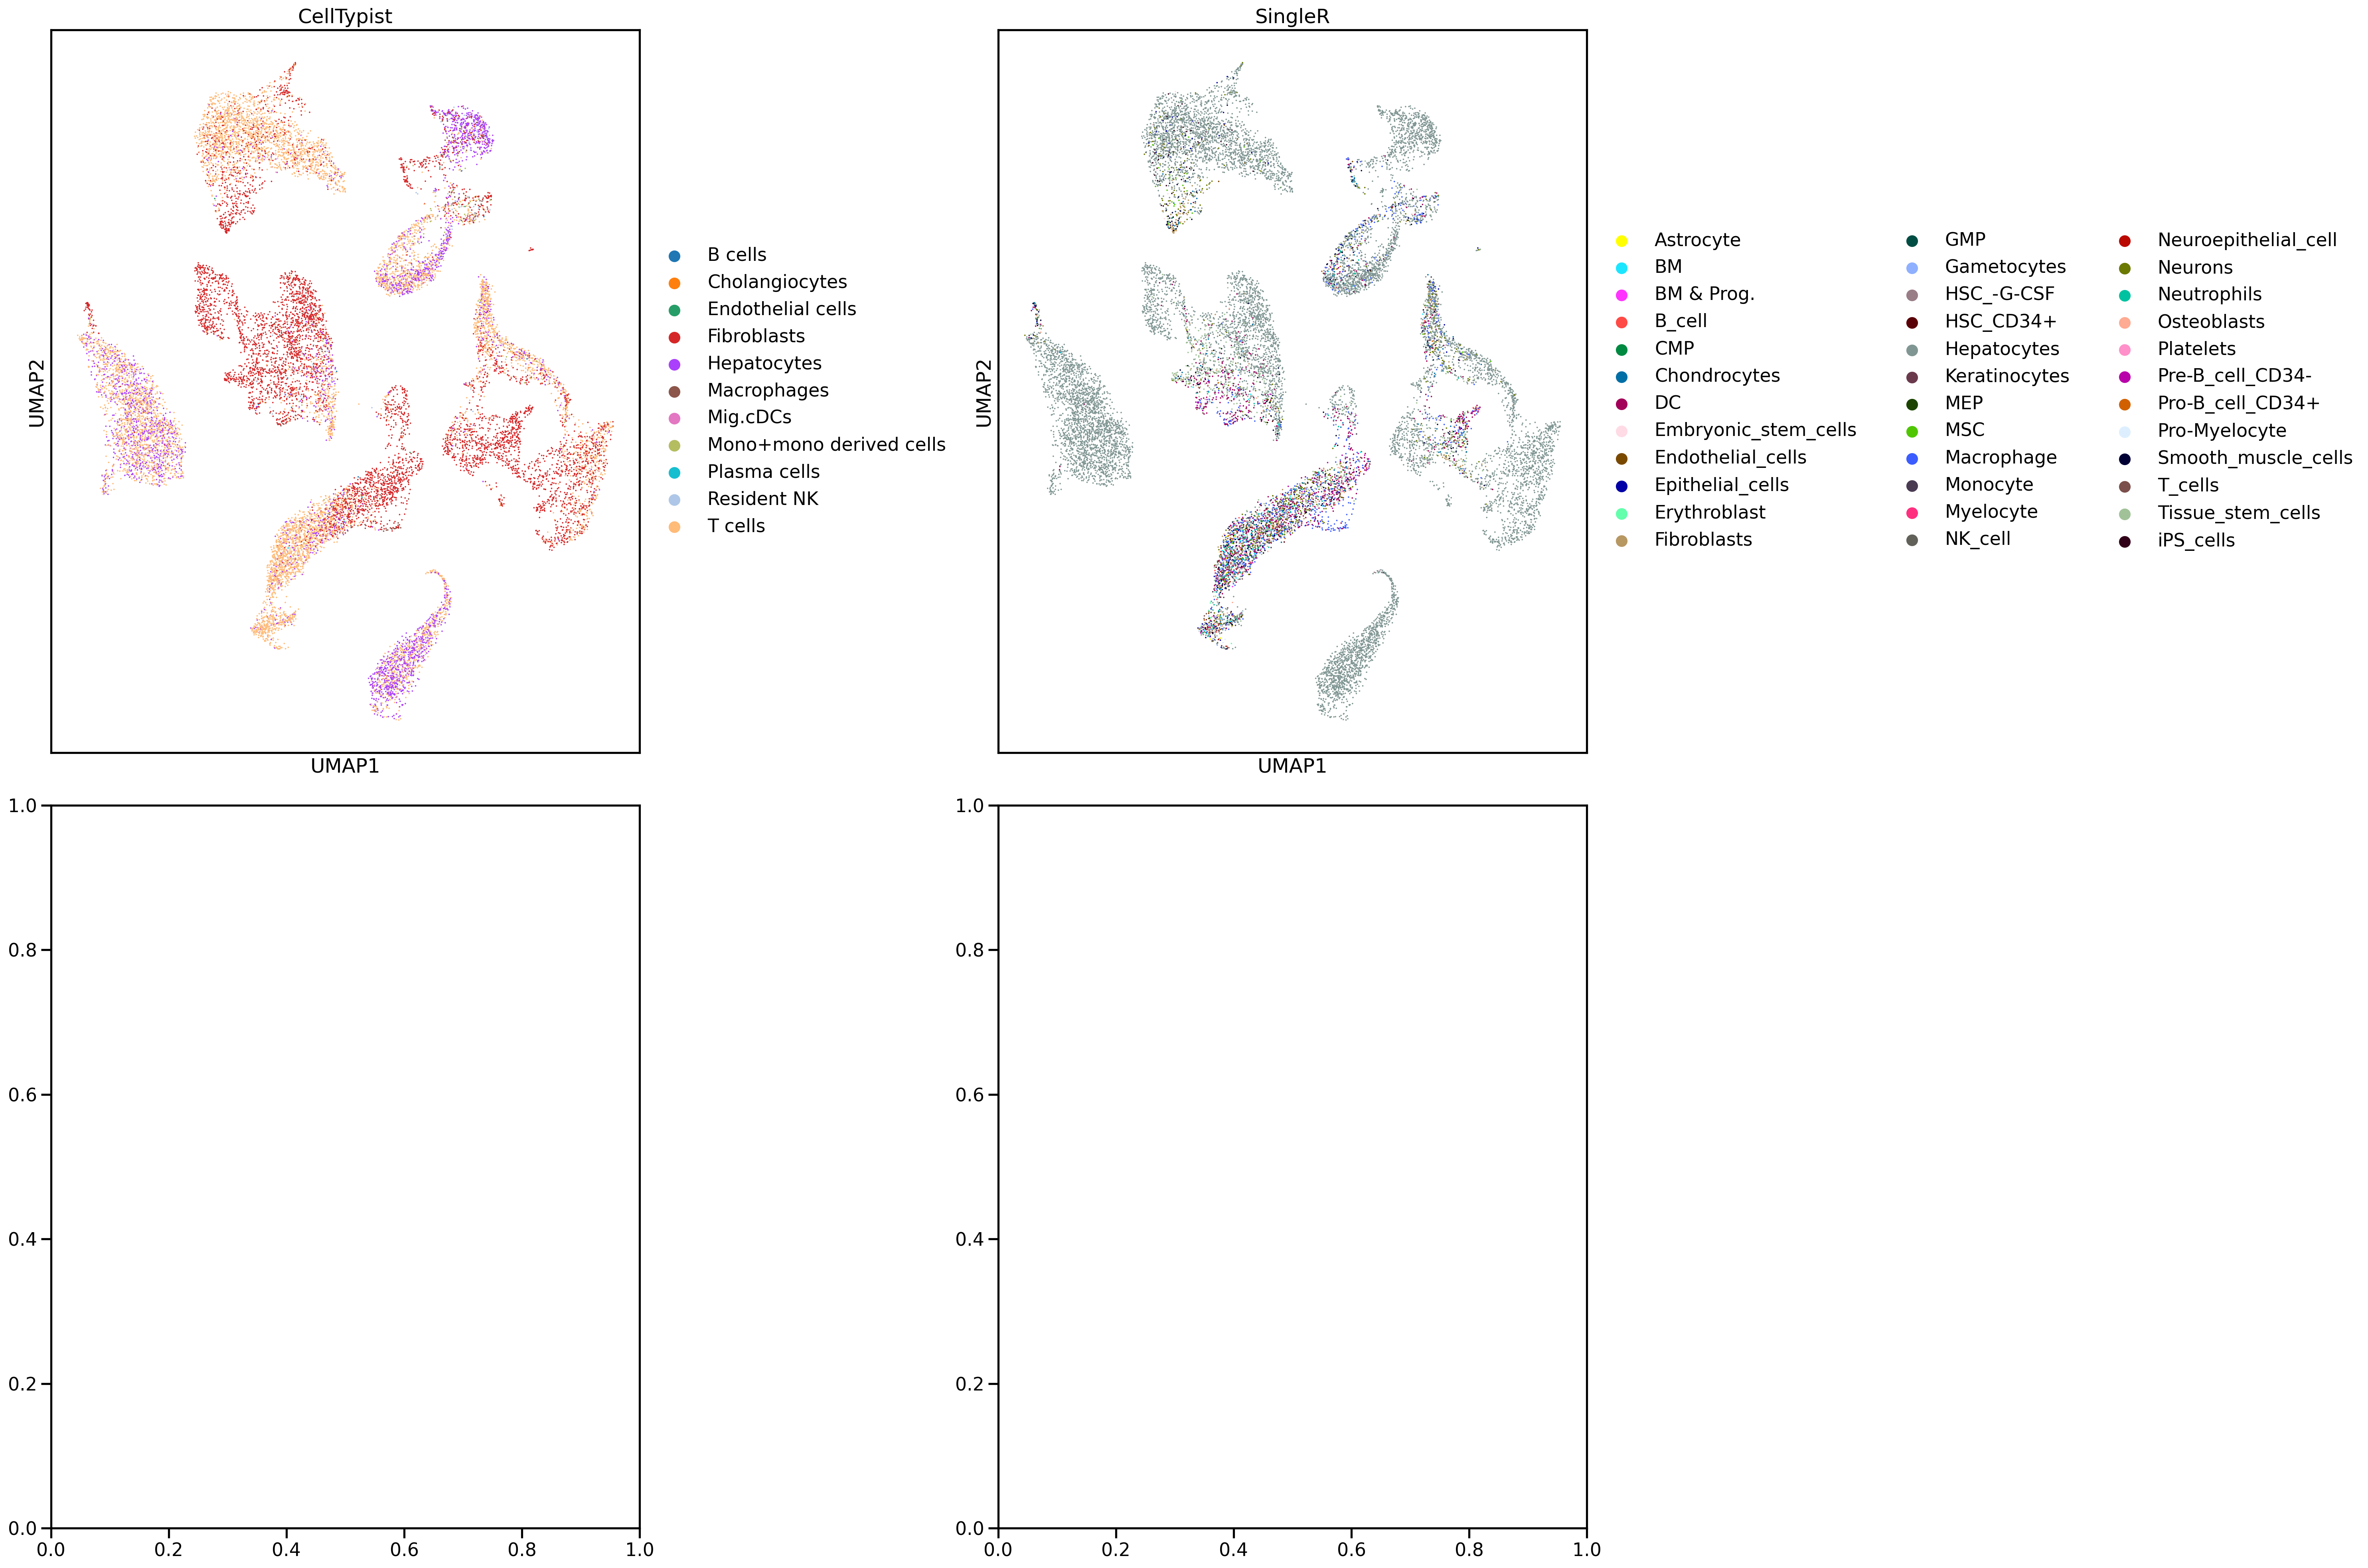

In [83]:
# --------------------------------------------------------------------
# 5. Comparison of Annotations
# --------------------------------------------------------------------
# Plot UMAPs side by side with different annotations for comparison
fig, axes = plt.subplots(2, 2, figsize=(30, 20))
sc.pl.umap(combined_ad, color="predicted_cell_type", title="CellTypist", ax=axes[0, 0], show=False)
sc.pl.umap(combined_ad, color="SingleR_annotation", title="SingleR", ax=axes[0, 1], show=False)
#sc.pl.umap(combined_ad, color="Azimuth_annotation", title="Azimuth", ax=axes[2], show=False)
#sc.pl.umap(combined_ad, color="scType_annotation", title="scType", ax=axes[3], show=False)
plt.tight_layout()
plt.show()

In [74]:
# Check the dimensions of `singleR_result` in R to understand the mismatch
ro.r('''
    print(dim(singleR_result))
    print(length(singleR_result$labels))
    print(length(colnames(singleR_result)))
''')

# Adjusting the row names based on actual lengths to create the DataFrame in R
ro.r('''
    # Create a data frame without specifying row names directly
    singleR_df <- data.frame(SingleR_annotation = singleR_result$labels)
''')

# Retrieve the DataFrame from R to Python
singleR_df = ro.r('singleR_df')

# Convert the R DataFrame to a Pandas DataFrame
singleR_df_py = pandas2ri.rpy2py(singleR_df)

# Add the annotation to the `obs` attribute of your AnnData object
combined_ad.obs["SingleR_annotation"] = singleR_df_py["SingleR_annotation"].values

[1] 17292     4
[1] 17292
[1] 4


In [6]:
print(combined_ad.obs["predicted_cell_type"])
print(combined_ad.obs["SingleR_annotation"])

AAACAGAGCGACTCCT-1-HCC5NR        T cells
AAACAGCTTTCAGAAG-1-HCC5NR    Hepatocytes
AAACAGGGTCTATATT-1-HCC5NR    Hepatocytes
AAACCGGGTAGGTACC-1-HCC5NR        T cells
AAACCTCATGAAGTTG-1-HCC5NR    Hepatocytes
                                ...     
TTGTTGTGTGTCAAGA-1-HCC4R     Fibroblasts
TTGTTTCACATCCAGG-1-HCC4R     Fibroblasts
TTGTTTCATTAGTCTA-1-HCC4R     Fibroblasts
TTGTTTCCATACAACT-1-HCC4R     Fibroblasts
TTGTTTGTGTAAATTC-1-HCC4R         T cells
Name: predicted_cell_type, Length: 17292, dtype: category
Categories (12, object): ['B cells', 'Cholangiocytes', 'Circulating NK/NKT', 'Endothelial cells', ..., 'Neutrophils', 'Plasma cells', 'Resident NK', 'T cells']
AAACAGAGCGACTCCT-1-HCC5NR          Hepatocytes
AAACAGCTTTCAGAAG-1-HCC5NR          Hepatocytes
AAACAGGGTCTATATT-1-HCC5NR          Hepatocytes
AAACCGGGTAGGTACC-1-HCC5NR          Hepatocytes
AAACCTCATGAAGTTG-1-HCC5NR          Hepatocytes
                                   ...        
TTGTTGTGTGTCAAGA-1-HCC4R     Tissue_stem_cells
TT

In [60]:
# Imp Check: To check number of Common Genes Between Reference and AnnData Object
# Convert AnnData var_names to a set (Python set for efficient comparison)
combined_ad_genes = set(combined_ad.var_names)

# Push the Python variable into R's global environment
ro.globalenv['combined_ad_genes'] = list(combined_ad_genes)

# Run R code using `ro.r` for commands you would run in R
ro.r('''
    library(celldex)
    ref_data <- celldex::HumanPrimaryCellAtlasData()
    
    # Ensure that combined_ad_genes is accessible in R
    common_genes <- intersect(rownames(ref_data), combined_ad_genes)
    #print(common_genes)
''')

test_genes = set(data_matrix_df.columns)
ref_genes = set(ro.r('rownames(ref_data)'))  # This gets the row names (genes) from the reference data
common_genes = test_genes.intersection(ref_genes)
print(f"Number of common genes: {len(common_genes)}")

Number of common genes: 1535


In [ ]:
#Notes and Requirements
#CellTypist: This is already performed in combined_ad.obs["predicted_cell_type"].
#SingleR: Requires SingleR and celldex R packages. You may need to install them in R by running install.packages('SingleR') and install.packages('celldex').
#Azimuth: Uses Seurat’s Azimuth for cell type annotation. Install Seurat and Azimuth in R.
#scType: Ensure that scType is installed. This method requires a marker gene file in .csv format, which should contain specific markers for each cell type.